<a href="https://colab.research.google.com/github/ariel-hedvat/AdvancedMLDLCourseAssignments/blob/main/Assignment%20II%20-%20NLP/Assignment_II_Group_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1><font size=6>Assignment 2 : NLP : Seinfeld or Friends?</font></h1>

  <u>Group members:</u><br>
  - Ariel Hedvat<br>
  - Shiraz Israeli<br>
  - Yuval Bakirov<br>
  - Eitan Bakirov

<br>

This project aims to distinguish dialogue lines from the TV shows Seinfeld and Friends. The dataset includes dialogue text, character information, and show labels. The goal is to build a model trained on dialogues of characters and classifies whether a new dialogue is from Seinfeld or Friends, then evaluate its accuracy on a test set.<br>
Also, we explore the results of the model on each character.
</div>


<div class="markdown-google-sans">
  <h1><font size=5>Data</font></h1>
</div>

The dataset comprises five columns: <br>
- Dialogue - indicating spoken lines<br>
- Character - denoting the speaker <br>
- Episode - specifying the episode number <br>
- Show - identifying the television series <br>
- Dialogue_length - quantifying the length of each dialogue entry.<br><br>

In our model we will only use the features: "Dialouge" (Sample) and "Show" (Label) during the training.<br><br>

<div class="markdown-google-sans">
  <h1><font size=5>Table of Contents</font></h1>

>[Import Libraries](#scrollTo=-_VBJ0JlYLKI)

>[Loading the data](#scrollTo=kXwOL606ZfUN)

>[EDA & Pre- Processing](#scrollTo=P8cTl07AZgyg)

>>[Text Cleaning](#scrollTo=YahuK9cqYcyC)

>>[Special character removal](#scrollTo=rktALPaIYimc)

>>[Stop words removal](#scrollTo=oI-pgoYYYnZe)

>>[Stemming](#scrollTo=Tdei7JlEc_Ea)

>>[Train-test-valdiation split](#scrollTo=mG1TBityfg1-)

>>[Labeling](#scrollTo=EIruMKat5Rx3)

>>[Bag Of Words](#scrollTo=Rh7H8mrM5o2c)

>>[TF-IDF](#scrollTo=Uz8y6fvWhtdA)

>[Modeling](#scrollTo=_58J58NQVpBV)

>[Explore Our results](#scrollTo=vbjiKHyi7Irm)



#  Import Libraries

In [91]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup
import re
from sklearn.preprocessing import LabelBinarizer

import nltk
from nltk.tokenize.toktok import ToktokTokenizer

from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer

from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding, MaxPooling1D, BatchNormalization

from keras.models import Sequential
from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Loading the data

In [92]:
# Data Loading for Train
url = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/Assignment%20II%20-%20NLP/train.csv'
full_train_data = pd.read_csv(url)

#TODO
#train_set = full_train_data.copy()
#x_train = full_train_data.drop('Show', axis=1).copy()
#y_train = full_train_data['Show'].copy()

In [93]:
# Data Loading for Test
url_test = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/Assignment%20II%20-%20NLP/test.csv'
full_test_data = pd.read_csv(url_test)

#TODO
#test_set = full_test_data.copy()
#x_test = full_test_data.drop('Show', axis=1).copy()
#y_test = full_test_data['Show'].copy()

# **EDA & Pre- Processing**

First, let's look at our data:

In [94]:
full_train_data

,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13
...,...,...,...,...,...
70400,Pretty much.,jerry,S05E09,Seinfeld,2
70401,"Oh, well um, not right now. Y'know I’m just g...",phoebe,Season-03 Episode-05-The One With Frank Jr.,Friends,22
70402,"Ooh, I think I wanna trade circles.",phoebe,Season-07 Episode-22-The One With Chandler’s Dad,Friends,7
70403,"Hey, hey, what is this? What's going on here?",jerry,S05E03,Seinfeld,9


Before moving on looking at the data, let's check for missing values:

In [95]:
# Train set
missing_values_count = full_train_data.isnull().sum()
print("Missing values count per column in train data:")
print(missing_values_count)

Missing values count per column in train data:
Dialogue           0
Character          0
Episode            0
Show               0
Dialogue_length    0
dtype: int64


In [96]:
# Test set
missing_values_count = full_test_data.isnull().sum()
print("Missing values count per column in test data:")
print(missing_values_count)

Missing values count per column in test data:
Dialogue           0
Character          0
Episode            0
Show               0
Dialogue_length    0
dtype: int64


No missing values found!

Checking whether the train data is balanced:

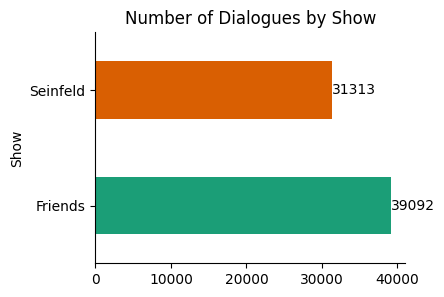

In [97]:
# Grouping by 'Show' and getting size
grouped_data = full_train_data.groupby('Show').size()

plt.figure(figsize=(4, 3))  # Adjust width and height as needed

# Plotting the grouped data
ax = grouped_data.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adding count numbers near the plots with slight adjustments
for i, count in enumerate(grouped_data):
    ax.text(count + 0.1, i, str(count), va='center', ha='left')

# Adding title
plt.title("Number of Dialogues by Show")

plt.show()

Looks like "Friends" has sligthly more dialouges than "Seinfeld", but overall it looks pretty balanced.

But we are expecting to see better results for "Friends" since there are more samples to learn from.

In [98]:
# Dialouge exmaple
full_train_data.iloc[1, 0]

' (to Joey) Are you gonna be embarrassed going up there having nothing prepared?'

Let's look at the number of dialogues each character has in its show:

In [99]:
# Define a function to plot histogram with count numbers
def plot_histogram_with_counts(ax, data, title, xlabel, ylabel, color):
    bars = ax.bar(data.index, data.values, color=color)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(data.index)
    ax.set_xticklabels(data.index, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    # Adding count numbers above each column
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom')


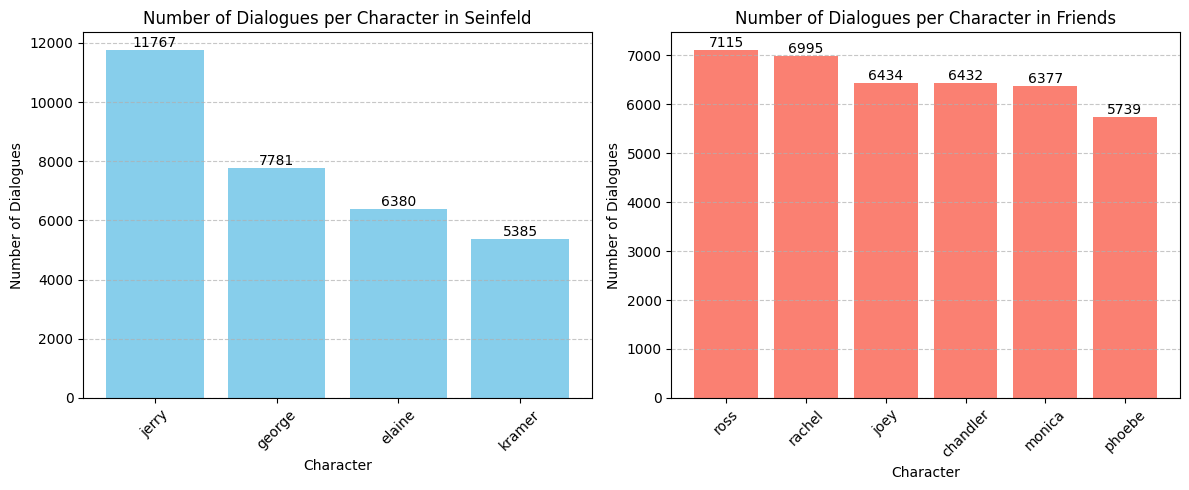

In [100]:
# Filter data for Seinfeld
seinfeld_df = full_train_data[full_train_data['Show'] == 'Seinfeld']
# Group by character and count dialogues
seinfeld_character_counts = seinfeld_df['Character'].value_counts()

# Filter data for Friends
friends_df = full_train_data[full_train_data['Show'] == 'Friends']
# Group by character and count dialogues
friends_character_counts = friends_df['Character'].value_counts()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for Seinfeld
plot_histogram_with_counts(axes[0], seinfeld_character_counts, 'Number of Dialogues per Character in Seinfeld', 'Character', 'Number of Dialogues', 'skyblue')

# Plot histogram for Friends
plot_histogram_with_counts(axes[1], friends_character_counts, 'Number of Dialogues per Character in Friends', 'Character', 'Number of Dialogues', 'salmon')

plt.tight_layout()
plt.show()

We can see that: <br>
Seinfeld - Jerry has much more dialogues than the others. <br>
Friends - the number of dialogues is more balanced.

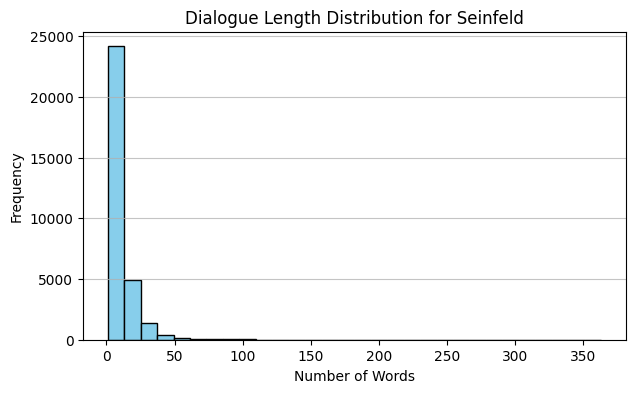

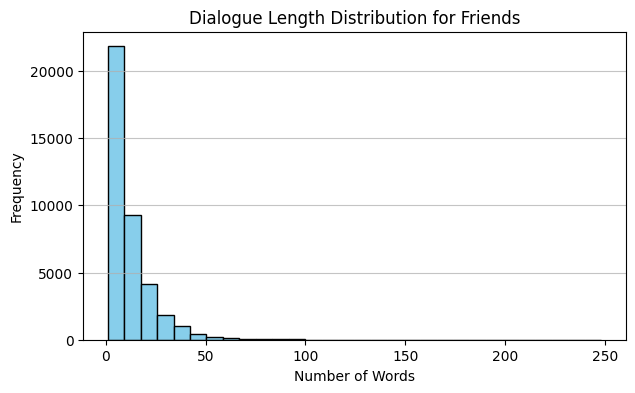

In [101]:
# Dialogues Length Distribution
# Plotting the distribution of dialogue lengths for each show to understand the typical length of dialogues

def plot_dialogue_length_distribution(data, show_name):
    show_data = data[data['Show'] == show_name]
    dialogue_lengths = show_data['Dialogue'].apply(lambda x: len(x.split()))

    plt.figure(figsize=(7, 4))
    plt.hist(dialogue_lengths, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Dialogue Length Distribution for {show_name}')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Example usage
plot_dialogue_length_distribution(full_train_data, 'Seinfeld')
plot_dialogue_length_distribution(full_train_data, 'Friends')


We can see that most of the sentences are short at both shows.

In [102]:
# Function that finds the most common words
def count_words_custom(col):
    # Create an empty dictionary to store word counts
    word_counts = {}

    # Iterate over each row in the column
    for row in col:
        # Convert dialogue to lowercase and split into words
        words = row.lower().split()

        # Iterate over each word in the row
        for word in words:
            # Update word count dictionary
            word_counts[word] = word_counts.get(word, 0) + 1

    # Sort word counts by value in descending order
    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    # Extract top 20 words and their counts
    top_words = [word for word, count in sorted_word_counts[:20]]
    top_counts = [count for word, count in sorted_word_counts[:20]]

    # Plot bar chart
    plt.figure(figsize=(15, 5))
    plt.bar(top_words, top_counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top 20 Most Common Words')
    plt.xticks(rotation=45)
    plt.show()

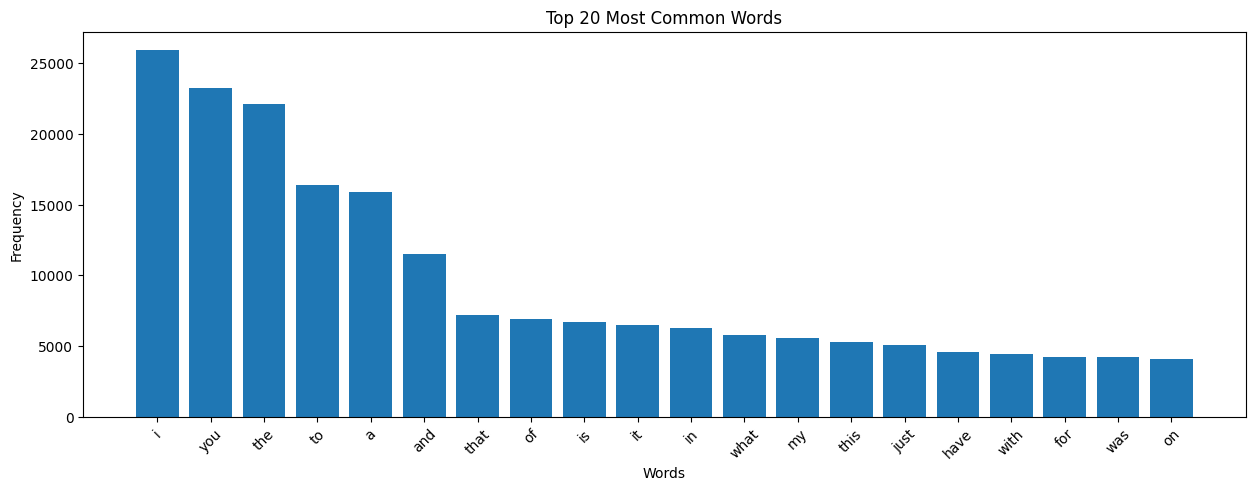

In [103]:
count_words_custom(full_train_data['Dialogue'])

We can see that all the most common words are Stop Words. We want to see the frequency without them.

For that we will implement data preprocessing steps:

## Text cleaning

In [104]:
# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

In [105]:
# Apply function on 'Dialogue' column
full_train_data['Dialogue'] = full_train_data['Dialogue'].apply(remove_between_square_brackets)
full_test_data['Dialogue'] = full_test_data['Dialogue'].apply(remove_between_square_brackets)

In [106]:
full_train_data.iloc[1, 0]

' (to Joey) Are you gonna be embarrassed going up there having nothing prepared?'

## Special character removal

In [107]:
# Define function for removing special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

In [108]:
# Apply function on Dialogue column
full_train_data['Dialogue'] = full_train_data['Dialogue'].apply(remove_special_characters)
full_test_data['Dialogue'] = full_test_data['Dialogue'].apply(remove_special_characters)

In [109]:
full_train_data.iloc[1, 0]

' to Joey Are you gonna be embarrassed going up there having nothing prepared'

## Stop words removal

We will use the NLTK in order to find all the English stop words and take a look at a few of them:

In [110]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
print('Number of English stop words:', len(stopword_list))
print(stopword_list[:5])

Number of English stop words: 179
['i', 'me', 'my', 'myself', 'we']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [111]:
# Adding a progress bar to the output
tqdm.pandas()

# Function that removes the stop words from a given text
def remove_stopwords(text, is_lower_case=False):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [112]:
# Apply function on Dialogue column
full_train_data['Dialogue'] = full_train_data['Dialogue'].progress_apply(remove_stopwords)
full_test_data['Dialogue'] = full_test_data['Dialogue'].progress_apply(remove_stopwords)

  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

In [113]:
full_train_data.iloc[1, 0]

'Joey gonna embarrassed going nothing prepared'

Now we can run the word count again and see the desired plotting:

In [114]:
# TODO
# TO CHECK THESE WORDS : IM,  OH , AH

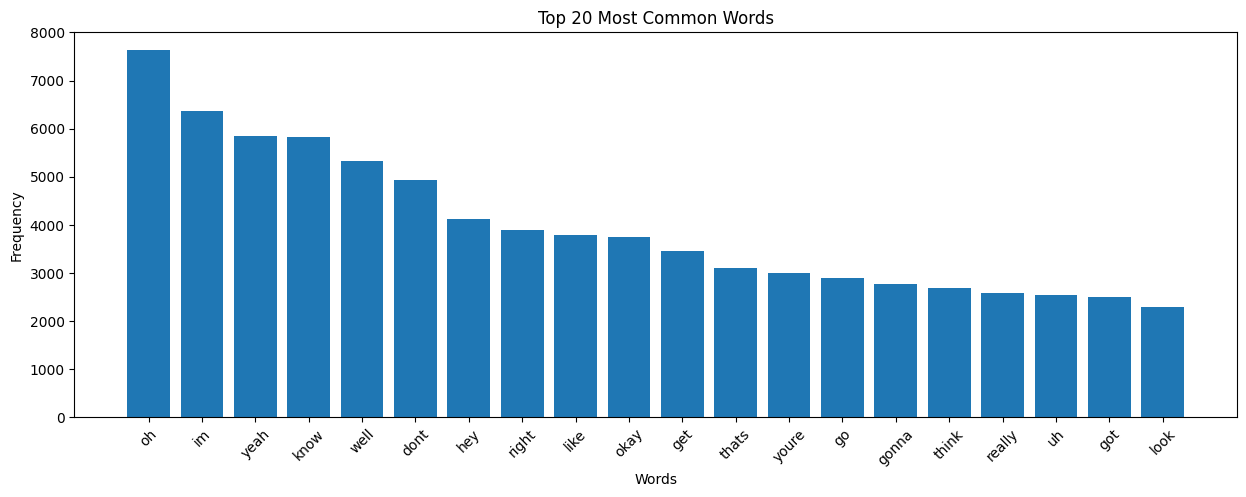

In [115]:
count_words_custom(full_train_data['Dialogue'])

Now we can see that there are no more stop words from the english corpus left.

## Stemming

In [116]:
# Stemming the text
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [117]:
# Apply function on Dialogue column
full_train_data['Dialogue'] = full_train_data['Dialogue'].progress_apply(simple_stemmer)
full_test_data['Dialogue'] = full_test_data['Dialogue'].progress_apply(simple_stemmer)

  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

In [46]:
full_train_data.iloc[1, 0]

'joey gonna embarrass go noth prepar'

## Train-test-validation split

In [118]:
X_train = full_train_data['Dialogue']
X_test = full_test_data['Dialogue']
y_train = full_train_data['Show']
y_test = full_test_data['Show']

In [121]:
# Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('\nx_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('\nx_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

x_train shape: (36047,)
y_train shape: (36047,)

x_test shape: (4245,)
y_test shape: (4245,)

x_val shape: (9012,)
y_val shape: (9012,)


## Labeling

We will change the labels "Friends" and "Seinfeld" to 1 and 0 accordingly:

In [122]:
# Making sure that there are only two unique labels
unique_shows = full_train_data['Show'].unique()
print("Unique values in the 'show' column:")
print(unique_shows)

Unique values in the 'show' column:
['Friends' 'Seinfeld']


As we saw above - we have only 2 values in 'Show' columns : Friends and Seindfeld. <br>
Therefore we will change our lable into binary numbers : Seinfeld = 0 , Friends = 1

In [126]:
custom_labels = ['Seinfeld', 'Friends']

# Initialize LabelBinarizer
lb = LabelBinarizer()

# Fit and transform custom labels
binary_labels = lb.fit_transform(custom_labels)

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

## Bag Of Words

TODO

In [51]:
#cv = CountVectorizer(analyzer='word')

#x_train_cv = cv.fit_transform(X_train)
#x_test_cv = cv.transform(X_test)
#x_val_cv = cv.transform(X_val)

#print('x_train_cv:', x_train_cv.shape)
#print('x_test_cv:', x_test_cv.shape)
#print('x_val_cv:', x_val_cv.shape)

And now each sample is a sparse Numpy matrix:

In [52]:
#x_train_cv[0]

In [53]:
#print(x_train_cv[0])

##TF-IDF

TODO

This is another way to convert the data to a numerical format. Like BoW, this algorithm is based on a term's popularity. However, its score is negatively correlated with its popularity in all documents.

This time we're going to use only 5K different terms as a cut-off.

In [54]:
# #from sklearn.feature_extraction.text import TfidfVectorizer
# #tv = TfidfVectorizer(analyzer='word', max_features=5000)

# #x_train_tv = tv.fit_transform(X_train)
# x_test_tv = tv.transform(X_test)
# x_val_tv = tv.transform(X_val)

# print('x_train_tv:', x_train_tv.shape)
# print('x_test_tv:', x_test_tv.shape)
# print('x_val_tv:', x_val_tv.shape)

Once again we have a sparse matrix:

In [55]:
# x_train_tv[0]

Containing continuous values between [0, 1]:

In [56]:
#print(x_train_tv[0])

# Modeling

Keras' tokenizer :
( Coverting words in the sentence into number representation )  

In [57]:
token = Tokenizer(lower=False)
token.fit_on_texts(X_train)

In [58]:
X_train = token.texts_to_sequences(X_train)
X_val = token.texts_to_sequences(X_val)
X_test = token.texts_to_sequences(X_test)

In [59]:
# Example
X_train[0]

[91, 419, 41, 31, 791, 117, 174, 519, 8, 354, 244]

Fix Size for all input vectors :

In [60]:
#Calculate the doc length
doc_len_list = [len(doc) for doc in X_train]

print ("Longest doc :", max(doc_len_list))
print("Shortet doc : ", min(doc_len_list))
print("Average doc:", np.mean(doc_len_list))

Longest doc : 185
Shortet doc :  0
Average doc: 5.791367800582345


Let's examine the distribution:

<Axes: ylabel='Count'>

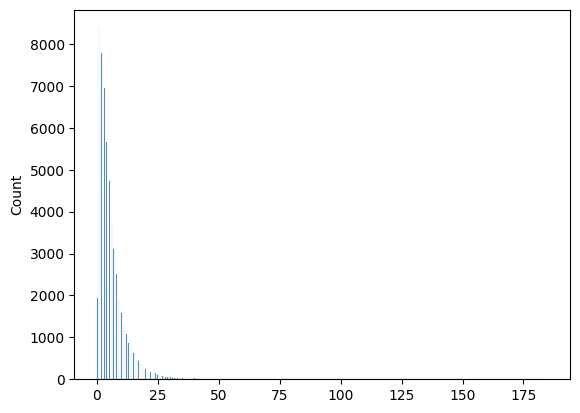

In [61]:
sns.histplot(doc_len_list)

We want to make sure that all sequences have the same length. According to the distribution, 40 seems like a reasonable shared value:

In [62]:
max_words = 40

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

Let's see what a sample look like:

In [63]:
X_train.shape

(56324, 40)

In [64]:
X_train[10, :]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  296,  274,  369,  100,  877,    3,
       4271, 4948,  174,    3,   59,   16,  369], dtype=int32)

In [65]:
total_words = len(token.word_index) + 1
total_words

15713

In [66]:
# model = Sequential()
# model.add(Embedding(input_dim=total_words, output_dim = 30, input_length = max_words))
# model.add(Conv1D(filters = 128, kernel_size = 2, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size = 2, strides=2, padding='valid'))
# model.add(Conv1D(256, 2, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size = 2, strides = 2, padding = 'valid'))
# model.add(Flatten())
# model.add(Dropout(0.65))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [67]:
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 2, batch_size = 16)


In [68]:
# model.evaluate(X_test, y_test)


Let's build the architecture:

TO DO Explain!!!!!

In [69]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=32, input_length=max_words))
model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 32)            502816    
                                                                 
 conv1d (Conv1D)             (None, 40, 16)            1552      
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           6272      
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dense (Dense)               (None, 128)               655488    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [70]:
# model = Sequential()
# model.add(Embedding(input_dim=total_words, output_dim=32, input_length=max_words))
# model.add(Conv1D(8, 3, padding='same', activation='relu'))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

Notice the first layer: an embedding layer. The purpose of embedding layers is to represent text data as meaningful vectors. Words that are similar to one another should have close values.

In [71]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)

Epoch 1/5
881/881 [==============================] - 35s 38ms/step - loss: 0.5357 - accuracy: 0.6947 - val_loss: 0.4920 - val_accuracy: 0.7272
Epoch 2/5
881/881 [==============================] - 31s 35ms/step - loss: 0.4348 - accuracy: 0.7714 - val_loss: 0.4916 - val_accuracy: 0.7294
Epoch 3/5
881/881 [==============================] - 35s 40ms/step - loss: 0.3768 - accuracy: 0.8034 - val_loss: 0.5331 - val_accuracy: 0.7282
Epoch 4/5
881/881 [==============================] - 34s 39ms/step - loss: 0.3259 - accuracy: 0.8302 - val_loss: 0.5977 - val_accuracy: 0.7264
Epoch 5/5
881/881 [==============================] - 31s 35ms/step - loss: 0.2850 - accuracy: 0.8491 - val_loss: 0.7066 - val_accuracy: 0.7200


Let's evaluate our model:

In [72]:
model.evaluate(X_test, y_test)

133/133 [==============================] - 1s 7ms/step - loss: 0.7259 - accuracy: 0.8243


[0.7259331941604614, 0.8242638111114502]

# Explore Our results

TO DO Explain!!!!!!

133/133 [==============================] - 1s 5ms/step


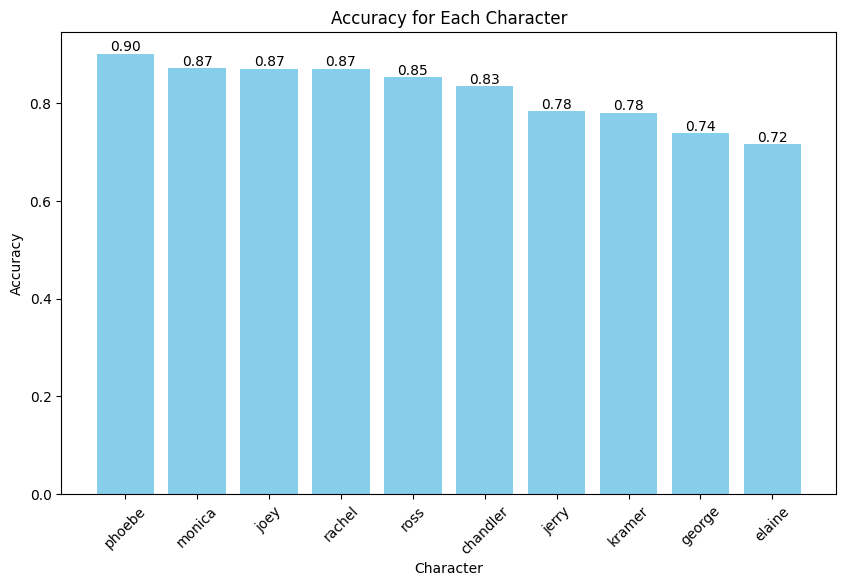

In [73]:
# Define a function to calculate accuracy for each character
def evaluate_accuracy_for_character(y_pred_probs, test_df, character):
    # Flatten y_test
    y_test_flat = y_test.flatten()

    #put 0 & 1 instead of Friends & Seinfeld
    test_df['Show'] = y_test_flat

    # Filter test data by character
    character_test_df = test_df[test_df['Character'] == character]

    # Get true labels for the character
    y_character_test = character_test_df['Show']

    # Filter predictions for the character
    character_indices = character_test_df.index
    y_character_pred_probs = y_pred_probs[character_indices]

    # Convert probabilities to binary labels
    y_character_pred = (y_character_pred_probs >= 0.5).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(y_character_test, y_character_pred)
    return accuracy

# Predict probabilities for all characters
y_pred_probs = model.predict(X_test)

# List of characters
characters = full_test_data['Character'].unique()

# Dictionary to store accuracy for each character
character_accuracy = {}

# Evaluate accuracy for each character
for character in characters:
    accuracy = evaluate_accuracy_for_character(y_pred_probs, full_test_data, character)
    character_accuracy[character] = accuracy

sorted_character_accuracy = dict(sorted(character_accuracy.items(), key=lambda item: item[1], reverse=True))

# Plotting results
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_character_accuracy.keys(), sorted_character_accuracy.values(), color='skyblue')
plt.title('Accuracy for Each Character')
plt.xlabel('Character')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.show()
